## Import Libraries


In [1]:
#Import Pennylane

import pennylane as qml

#Import Pytorch

import torch
from torch.utils.data import DataLoader

#Import other libraries

import numpy as np
from numpy.random import randn, randint
import os
import time
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


In [2]:
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Idea

The option pricing project had two main parts that used quantum algorithms: loading the underlying distributions, and amplitude estimation to calculate the payoff. In order to solve the former problem, Qiskit came up with the idea of using qGANs for loading the random distributions (see following tutorial):

https://qiskit.org/documentation/machine-learning/tutorials/04_qgans_for_loading_random_distributions.html

This is to a certain extent a question of quantum state preparation, where we are trying to find a quantum circuit that can prepare the state that describes the underlying distribution reflected in reality.

However, in the process of replicating Qiskit's solution and trying to improve on it, I realized that there was no need for a discriminator. Fundamentally, GANs in general are used for generative purposes, for unsupervised learning. However, in this case, we had the ideal result already: the distribution. Thus, it seemed to me that all we needed to do was to fit the results running the QNN with just one quantum layer to the distribution (which honestly makes it not exactly a NN), bypassing the need for a discriminator.

# Data

To demonstrate, we use a lognormal data-set. The data preparation phase consists of vectorizing (or binning) the data as with a quantum computer, we have a limited number of values we can use ($2^n$ where n is the number of qubits). For this particular example, we use 4 qubits, so we use 16 bins.

In [3]:
n_qubits = 4
n_bins = 2 ** 4

### Create the data

In [4]:
# Number training data samples
N = 10000

mu = 1
sigma = 1
data = np.random.lognormal(mean=mu, sigma=sigma, size=N)
np.random.shuffle(data)

### Put the data into bins

In [5]:
data_pre = np.round(data)
data = data_pre[data_pre <= n_bins]

bins = np.linspace(0, (n_bins - 1) , num= n_bins )
bin_indices = np.digitize(data, bins) - 1
data_temp = ((np.arange(n_bins) == bin_indices[:,None]).astype(int))

(array([ 444., 2321., 1847., 1332.,  944.,  655.,  516.,  362.,  282.,
         214.,  171.,  140.,  104.,   99.,   81.,  127.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

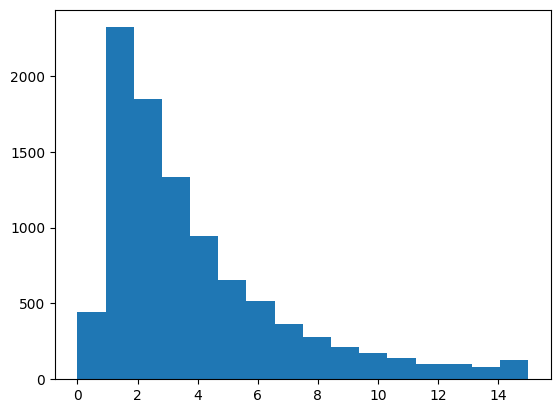

In [6]:
plt.hist(bin_indices, bins = n_bins)

In [7]:
data_dist = np.sum(data_temp, axis = 0)/10000

In [8]:
data_dist

array([0.0444, 0.2321, 0.1847, 0.1332, 0.0944, 0.0655, 0.0516, 0.0362,
       0.0282, 0.0214, 0.0171, 0.014 , 0.0104, 0.0099, 0.0081, 0.0127])

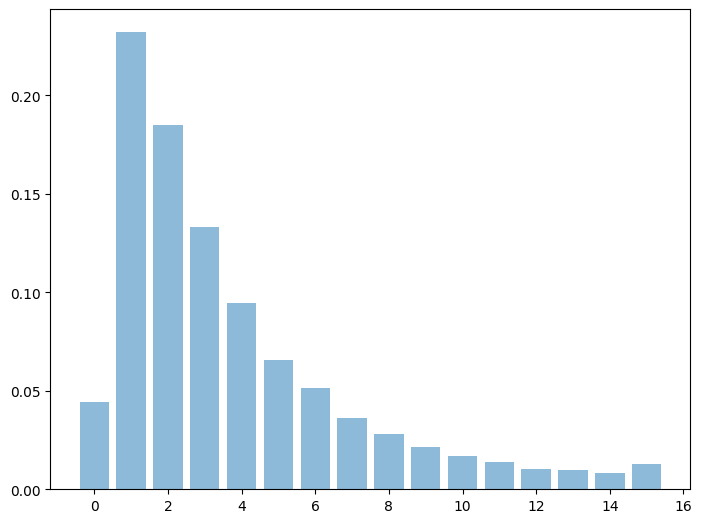

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(n_bins)
ax.bar(y, data_dist, alpha=0.5)
plt.show()

The variable data_dist above gives the distribution that we want to model.

# Model

We use Pennylane and PyTorch for this. Note that with Pennylane, it is easy to adapt to interface (like Braket or Qiskit) since we are tapping on their quantum computers.

In [10]:
dev = qml.device("default.qubit", wires= n_qubits, shots = 10000)

In [11]:
# Number of variational layers
q_depth = 2

Here we train using variational methods. 

Three parts of note:
- Initial Distribution
- Variational Quantum Circuit
- Measurement


In [12]:
@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):
    #qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    #qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits),rotation= qml.RY)
    
    # Init distribution
    for a in range(n_qubits):
        qml.Hadamard(wires=a)
    
    # Variational circuit
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RY(weights[2*(i*n_qubits + j) ], wires=j)
            qml.RZ(weights[2*(i*n_qubits + j) + 1], wires=j)
        for l in range(n_qubits):
            if (l == (n_qubits - 1)):
                qml.CNOT(wires=[l,0])
            else:
                qml.CNOT(wires=[l,l+1])
    
    for k in range(n_qubits):
        qml.RY(weights[(2*q_depth * n_qubits) + k ], wires=k)
        qml.RZ(weights[(2*q_depth * n_qubits) + k + 1], wires=k)
    
    # Measurement
    return qml.probs(wires=range(n_qubits))

In [13]:
n_args = 2*(q_depth +1) * n_qubits
weight_shapes = {"weights": n_args}

In [14]:
# Visualize the circuit
print(qml.draw(qnode)(inputs = 0, weights = np.random.rand(n_args)))

0: ──H──RY(0.31)──RZ(0.55)─╭●───────╭X──RY(0.22)──RZ(0.81)─╭●───────╭X──RY(0.33)──RZ(0.66)─┤ ╭Probs
1: ──H──RY(0.55)──RZ(0.35)─╰X─╭●────│───RY(0.42)──RZ(0.66)─╰X─╭●────│───RY(0.66)──RZ(0.09)─┤ ├Probs
2: ──H──RY(0.34)──RZ(0.11)────╰X─╭●─│───RY(0.21)──RZ(0.82)────╰X─╭●─│───RY(0.09)──RZ(0.79)─┤ ├Probs
3: ──H──RY(0.47)──RZ(0.16)───────╰X─╰●──RY(0.47)──RZ(0.62)───────╰X─╰●──RY(0.79)──RZ(0.20)─┤ ╰Probs


In [15]:
# Create the model 
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
layers = [qlayer]
model = torch.nn.Sequential(*layers)

In [16]:
# Define optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
loss = torch.nn.MSELoss()

We take a look at the initial randomized distribution of the quantum state generated by the quantum circuit.

In [17]:
noise = torch.normal(0, 1, size=(1,4))

# predict outputs
outputs = model(noise[0])
outputs

tensor([0.0370, 0.2492, 0.0356, 0.0037, 0.0808, 0.0326, 0.1296, 0.0299, 0.0254,
        0.0204, 0.0081, 0.0277, 0.1836, 0.0084, 0.1087, 0.0193],
       grad_fn=<ToCopyBackward0>)

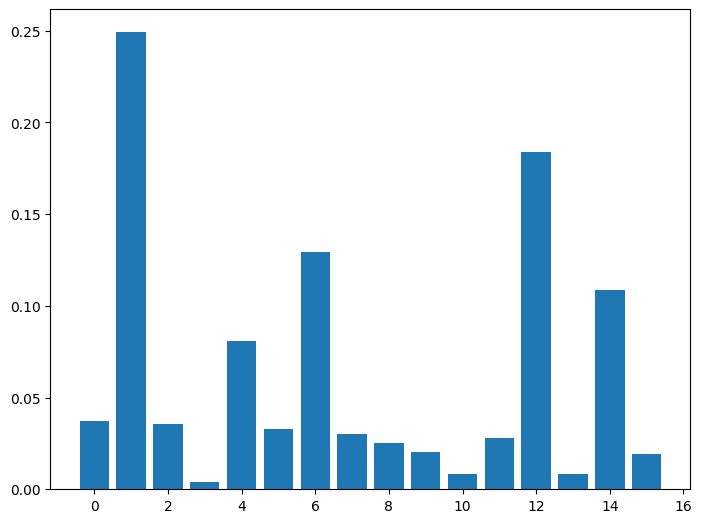

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, outputs.detach().numpy() )
plt.show()

# Training

In [19]:
# Decide number of epochs
n_epochs=2000

# Ideal probability distribution, in correct format
data_dist_t = torch.from_numpy(data_dist.astype("float32"))

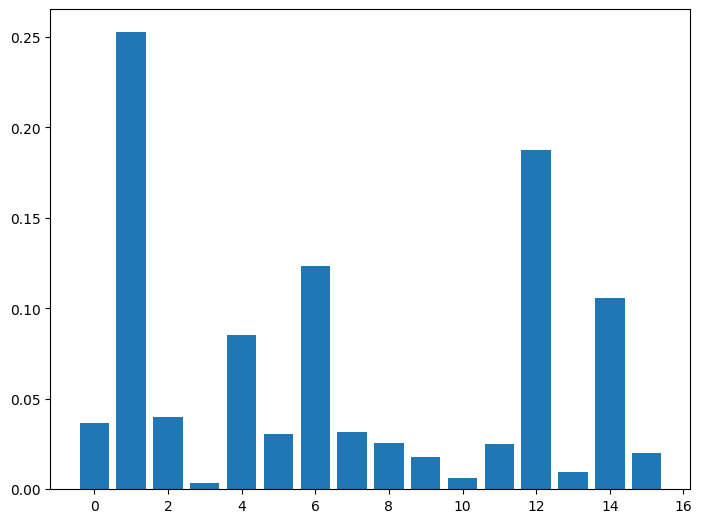

1 tensor(0.0053, grad_fn=<MseLossBackward0>)


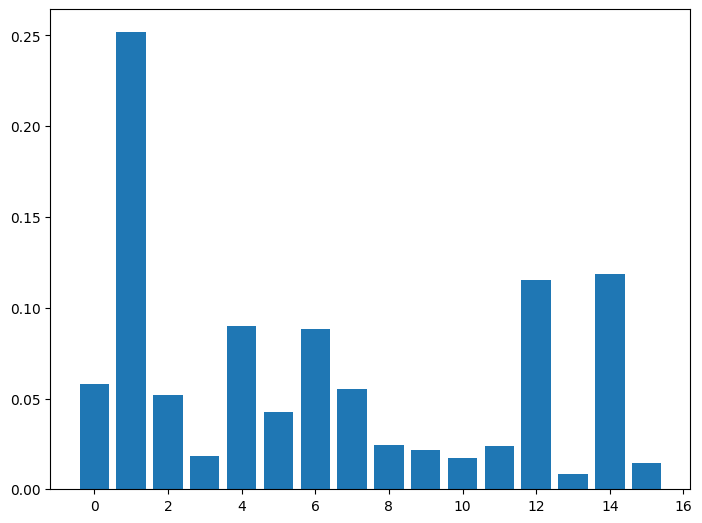

101 tensor(0.0037, grad_fn=<MseLossBackward0>)


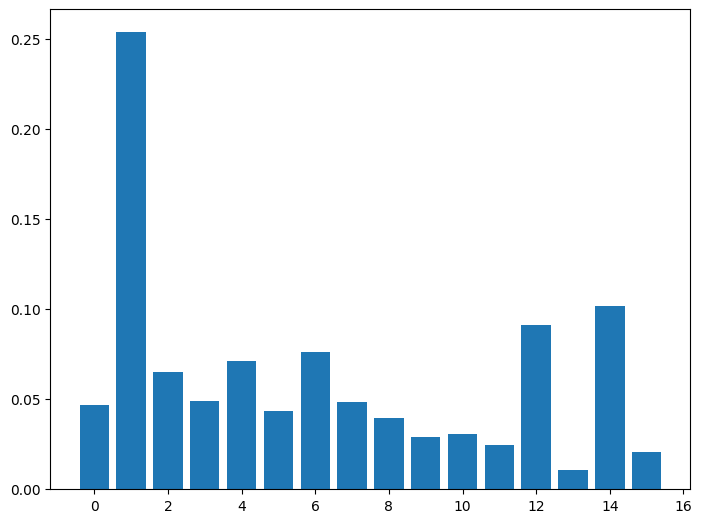

201 tensor(0.0024, grad_fn=<MseLossBackward0>)


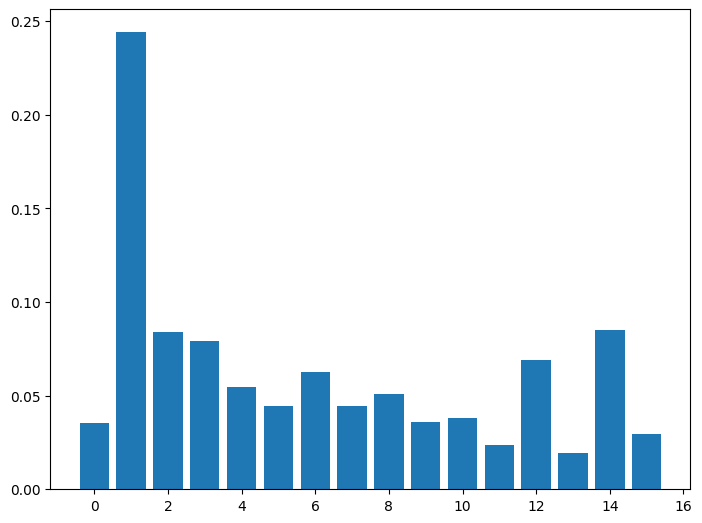

301 tensor(0.0016, grad_fn=<MseLossBackward0>)


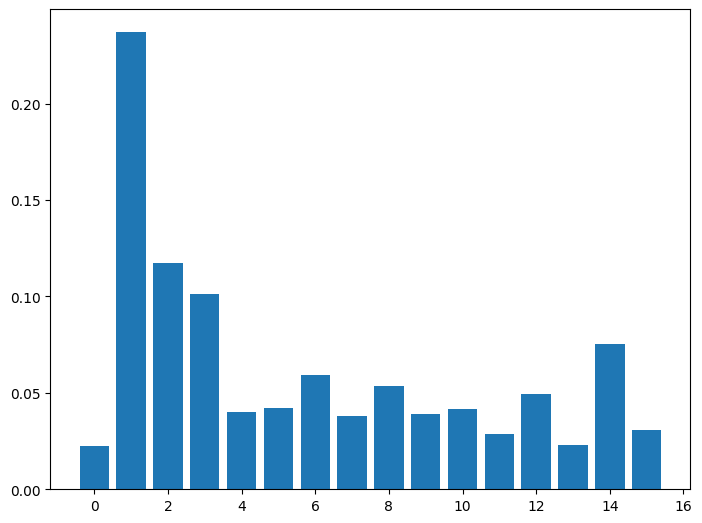

401 tensor(0.0012, grad_fn=<MseLossBackward0>)


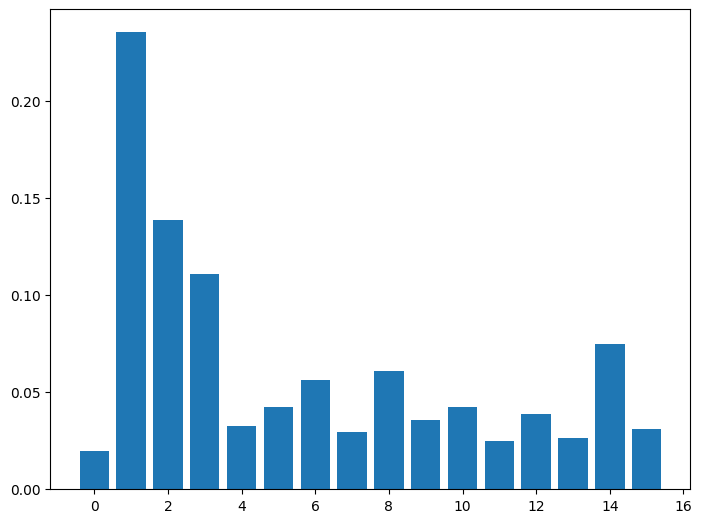

501 tensor(0.0009, grad_fn=<MseLossBackward0>)


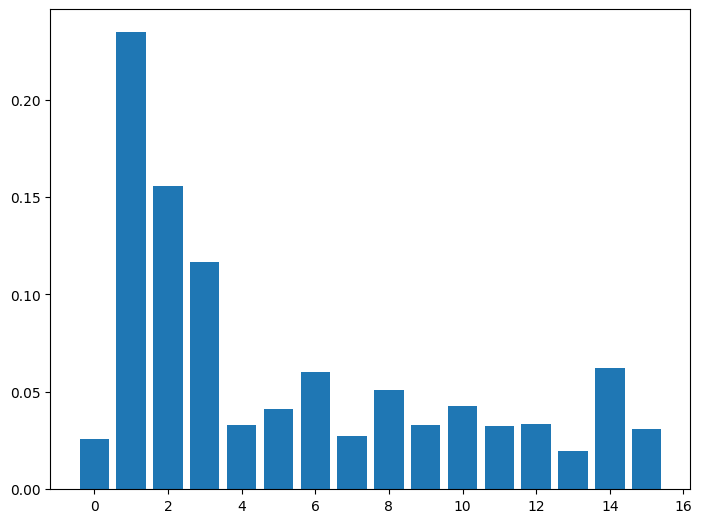

601 tensor(0.0007, grad_fn=<MseLossBackward0>)


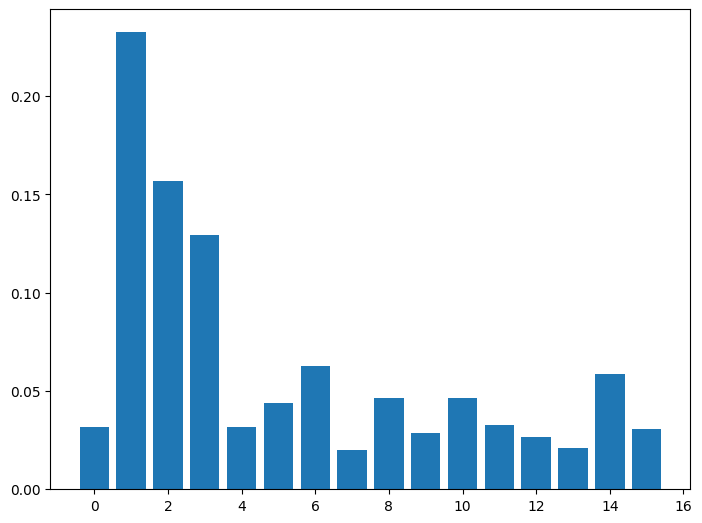

701 tensor(0.0007, grad_fn=<MseLossBackward0>)


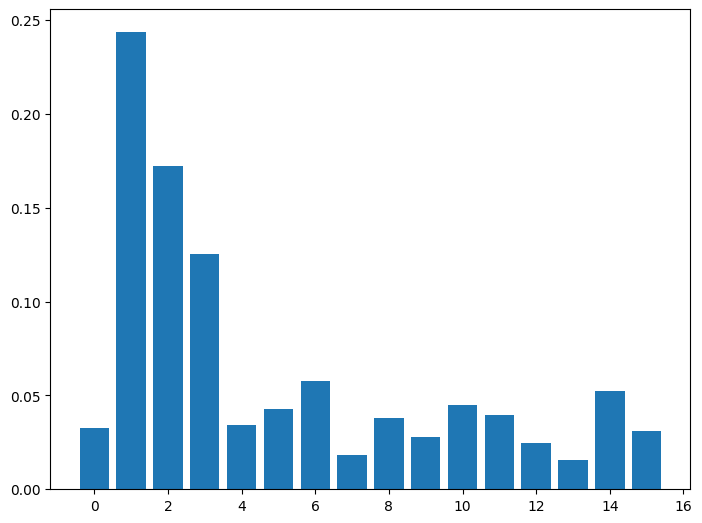

801 tensor(0.0005, grad_fn=<MseLossBackward0>)


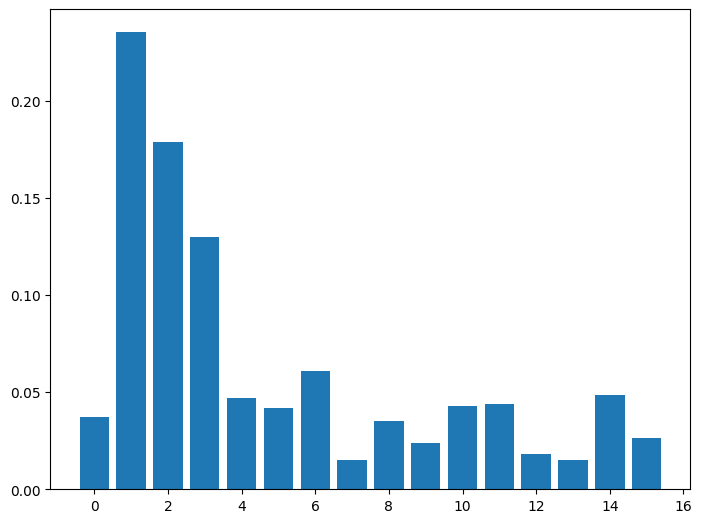

901 tensor(0.0004, grad_fn=<MseLossBackward0>)


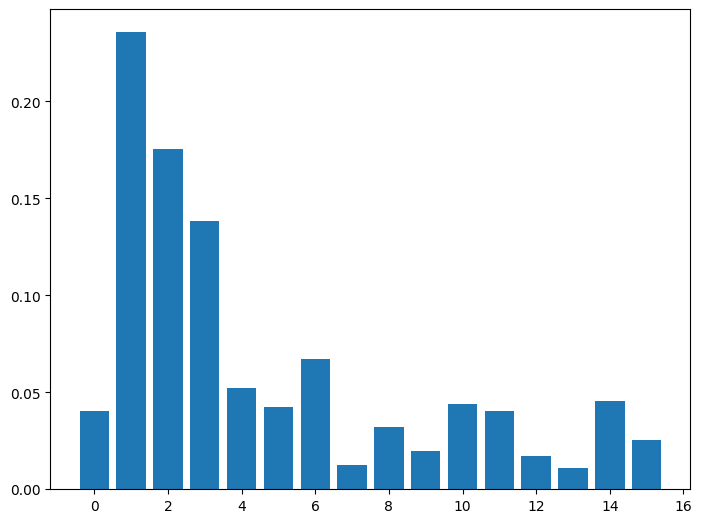

1001 tensor(0.0004, grad_fn=<MseLossBackward0>)


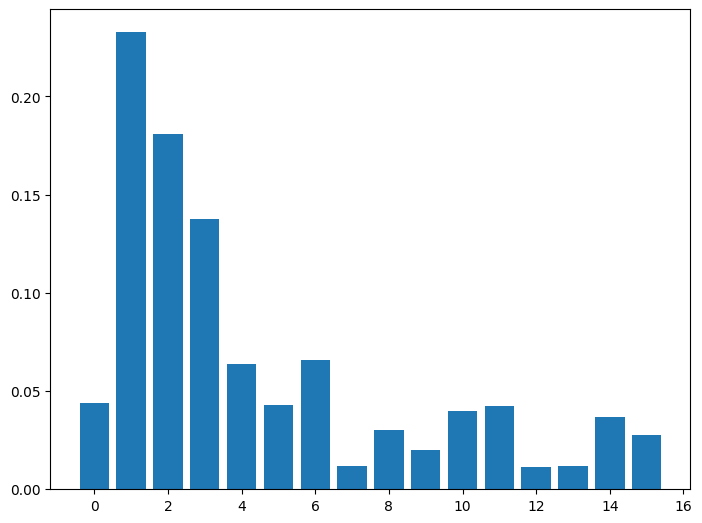

1101 tensor(0.0003, grad_fn=<MseLossBackward0>)


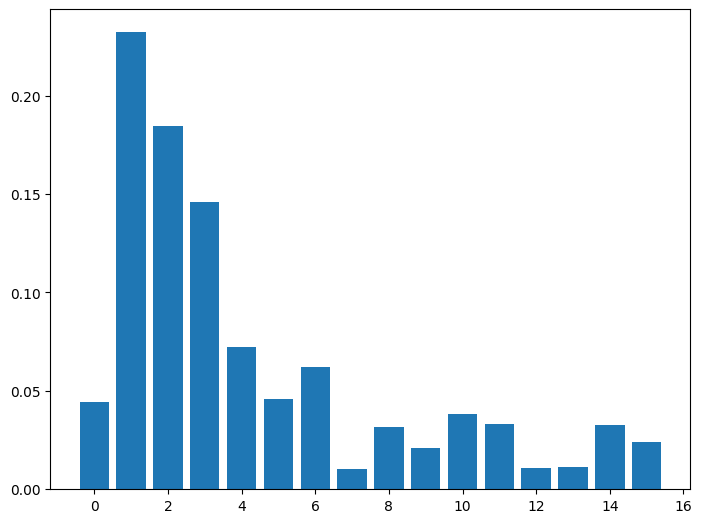

1201 tensor(0.0002, grad_fn=<MseLossBackward0>)


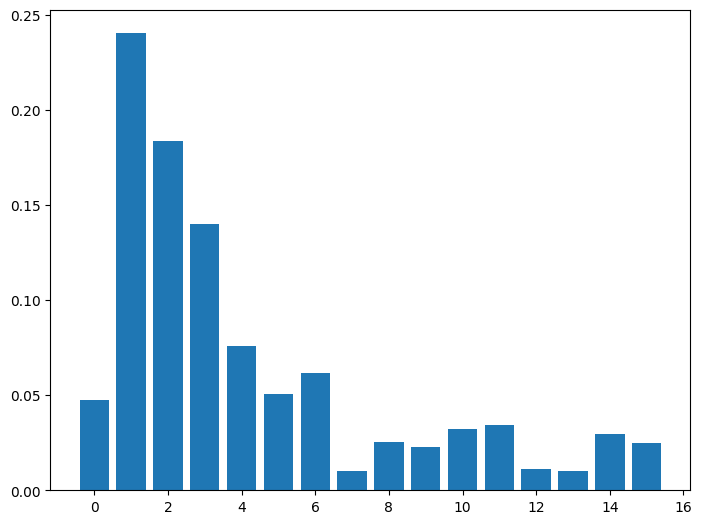

1301 tensor(0.0002, grad_fn=<MseLossBackward0>)


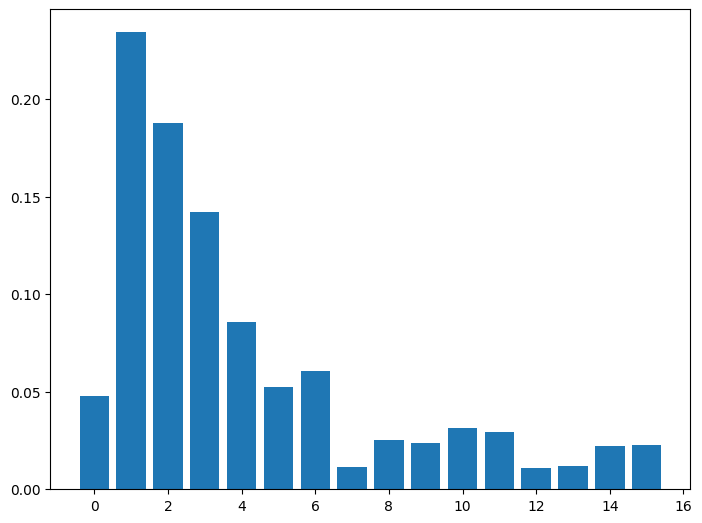

1401 tensor(0.0001, grad_fn=<MseLossBackward0>)


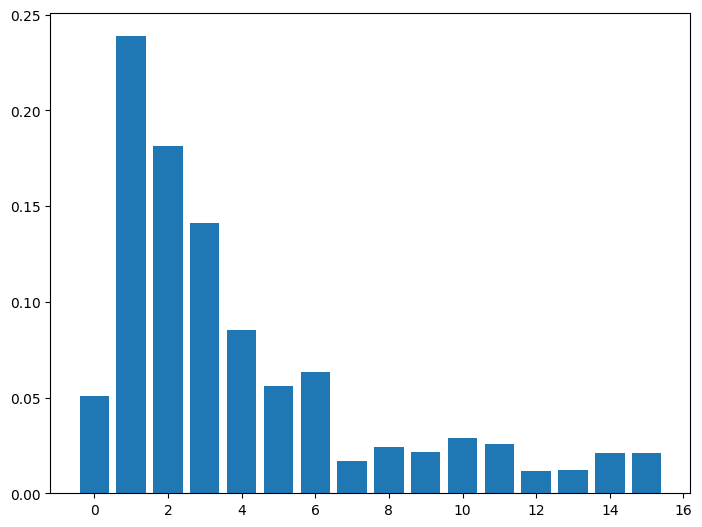

1501 tensor(7.7474e-05, grad_fn=<MseLossBackward0>)


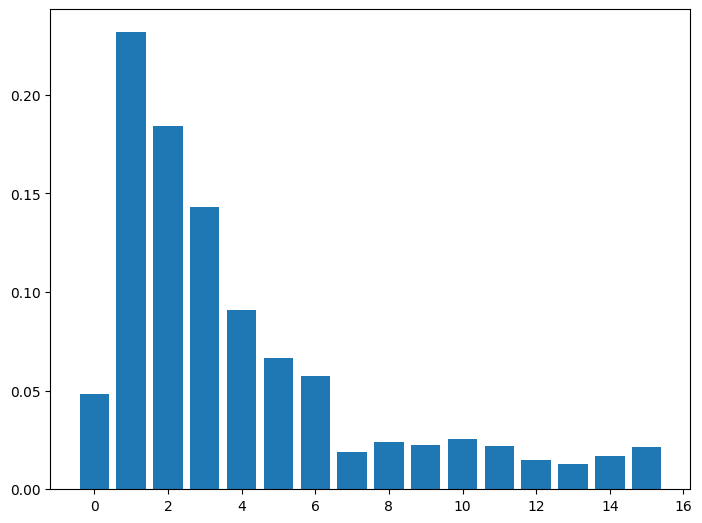

1601 tensor(5.4643e-05, grad_fn=<MseLossBackward0>)


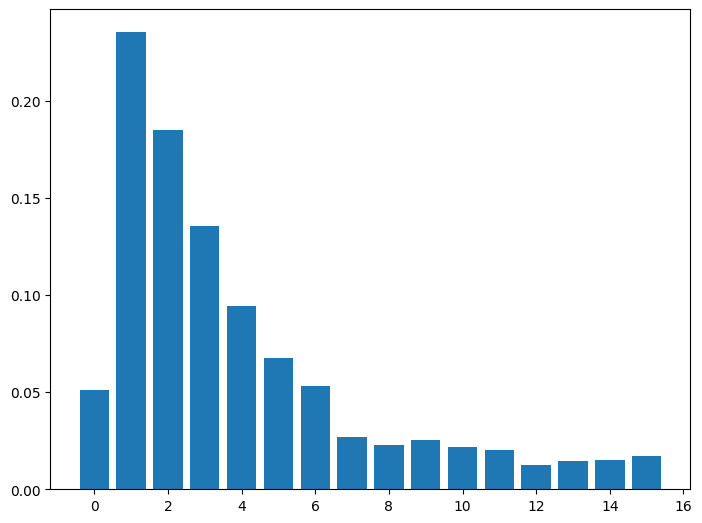

1701 tensor(2.5581e-05, grad_fn=<MseLossBackward0>)


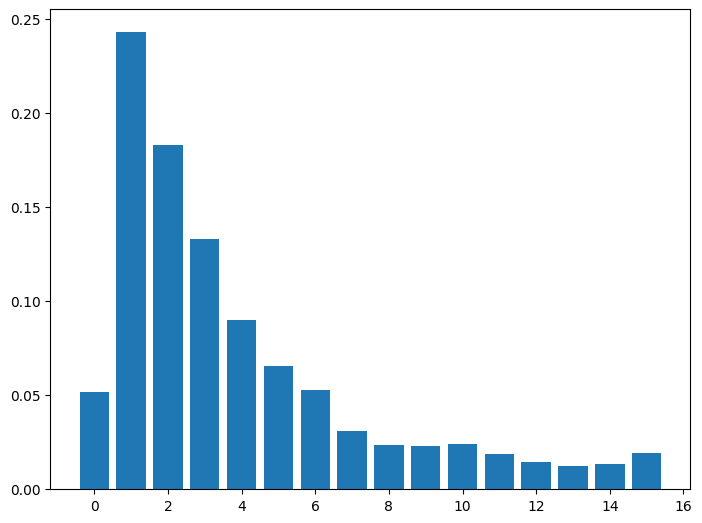

1801 tensor(1.7781e-05, grad_fn=<MseLossBackward0>)


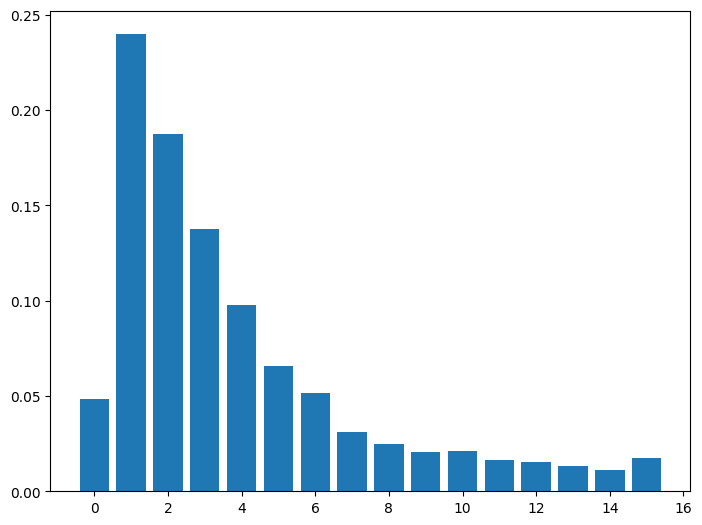

1901 tensor(1.4968e-05, grad_fn=<MseLossBackward0>)
Execution time 787.0212459564209


In [20]:
start = time.time()
seed = torch.normal(0, 1, size=(1, 4))
for i in range(n_epochs):
    if (i % 100 == 0): 
        test_data = model(seed[0])
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        y = range(16)
        ax.bar(y, test_data.detach().numpy() )
        plt.show()

    # new_dist = g_model.predict(seed)
    opt.zero_grad()

    loss_evaluated = loss(model(seed[0]), data_dist_t)
    loss_evaluated.backward()

    opt.step()

    if (i % 100 == 0): 
        print((i+1), loss_evaluated)

end = time.time()
print("Execution time", end - start)

# Visualizations

Compare the real data to the one generated by the quantum state.

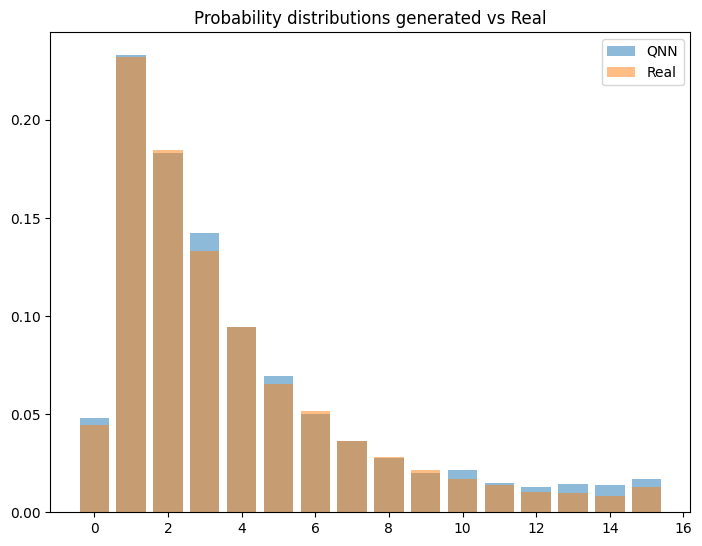

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, model(noise[0]).detach().numpy(), alpha=0.5, label = 'QNN' )
ax.bar(y, data_dist_t.detach().numpy(), alpha=0.5, label = 'Real' )
ax.legend()
plt.title("Probability distributions generated vs Real")
plt.show()